In [4]:
import numpy as np
import pylab as pl
from scipy.misc import *
import math
from sklearn.utils import shuffle
import matplotlib.pyplot as plotter

In [5]:
from pickle import *
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
        return dict

In [6]:
#Reading all the Data
datadict = unpickle("./Data/cifar-100-python/train")
xTrain = datadict[b'data']
yTrain = datadict[b'coarse_labels']
xtr= xTrain[:40000]
ytr= yTrain[:40000]
xval = xTrain[40000:]
yval = yTrain[40000:]

xtrt = xtr.reshape(40000,3,32,32)

datadicttest = unpickle("./Data/cifar-100-python/test")
xtest = datadicttest[b'data']
ytest = datadicttest[b'coarse_labels']
valid_examples = xtest.shape[0]

#Data Preprocessing (Zero Centering and Normalization)
xtr = np.array(xtr,dtype=np.float64)
xtr -= np.mean(xtr)
xtr /= 255
xval = np.array(xval,dtype=np.float64)
xval -= np.mean(xval)
xval /= 255
xtest = np.array(xtest,dtype=np.float64)
xtest -= np.mean(xtest)
xtest /= 255

In [7]:
#Softmax Function to Calculate Losses
def SoftmaxFn(classscores,y):                 
    exps = np.exp(classscores,dtype=np.float64)
    probability = exps / np.sum(exps, axis=1, keepdims=True)
    q = exps.shape[0]
    correct_log = -np.log(probability[np.arange(q),y] + 1e-9)             
    return correct_log,probability

#Leaky ReLU Implementation
def ReLUFwd(x):                               
    return np.maximum(0.1*x,x,dtype=np.float64)

#Forward Pass (MultAdd and ReLU)
def FwdPass(w,b,layers,E,x,MiniBatchSize):
    layers_step = []
    current = x[E*MiniBatchSize:(E+1)*MiniBatchSize]
    for q in range(len(layers)-1):
        HiddenLayer = ReLUFwd(np.dot(current,w[q])+b[q])
        layers_step.append(HiddenLayer)
        current = HiddenLayer
    return current,layers_step

#Back Propagation using Analytic Gradient Method
def BackwdPass(E,layers,layers_step,probability,ytr,Examples,w,MiniBatchSize):
    gradient_scores = probability
    gradient_scores[np.arange(MiniBatchSize),ytr[E*MiniBatchSize:(E+1)*MiniBatchSize]] -= 1
    gradient_scores /= MiniBatchSize
    derivative_step = gradient_scores
    dw = []
    db = []
    for i in reversed(range(len(layers_step)-1)):
        dw.append(np.dot(layers_step[i].T,derivative_step))
        db.append(np.sum(derivative_step,axis=0,keepdims=True))
        dh = np.dot(derivative_step,w[i+1].T)
        dh[layers_step[i] <= 0] *= 0.1
        derivative_step = dh
    dw.append(np.dot(xtr[E*MiniBatchSize:(E+1)*MiniBatchSize].T,dh))
    db.append(np.sum(dh,axis=0,keepdims=True))
    return dw,db

#Initializing Weights using Xavier/2
def XavierInit(layers):
    #random seed
    np.random.seed(5)
    for i in range(len(layers)-1):
        w.append(np.random.randn(layers[i],layers[i+1])/np.sqrt(layers[i]/2)) 
        b.append(np.zeros((layers[i+1])))
    return w,b

In [16]:
#Epochs
Epochs = 100

#Mini Batch Size and Layer Details
MiniBatchSize = 200
layers = [3072,1250,750,300,20]

#HyperParameters
learn_rate = 5e-3
reg = 1e-4         #lambda Regularization strength
beta1 = 0.9
beta2 = 0.999

In [17]:
#Initializing Momentum,Accum for ADAM
momentum = 0
accum = 0

#Initializing values to obtain best accuracy while training
max_acc = 0
Val_acc = 1e-3

#Initializing Needed arrays and values for the training
Examples = xtr.shape[0]
valid_examples = xval.shape[0]
w = []
b = []
Total_Training_Losses = []
Total_Validation_Losses = []
minimum_w = []
minimum_b = []
Loss_Per_Epoch_Total = []
Loss_Per_Epoch = []
scores = []

#Initializing Weights
w,b = XavierInit(layers)
    
for qq in range(Epochs):
    Loss_Per_iter_total = []
    Loss_Per_iter = []
    for E in range(int(math.floor(Examples/MiniBatchSize))):
        reg_loss = 0
        #Forward Passing and Finding Softmax Function Call
        scores,layers_step = FwdPass(w,b,layers,E,xtr,MiniBatchSize)
        loss,probability = SoftmaxFn(scores,ytr[E*MiniBatchSize:(E+1)*MiniBatchSize])
        #Calculating Regularization Loss and Adding to loss
        for j in range(len(w)):
            reg_loss += 0.5*reg*np.sum(w[j]*w[j])
        total_loss = loss + reg_loss
        #Adding Losses to be able to draw graph at the end
        Loss_Per_iter_total.append(np.mean(total_loss,dtype=np.float64))
        Loss_Per_iter.append(np.mean(loss,dtype=np.float64))
        #Backward Pass Using Analytic Graph
        dw,db = BackwdPass(E,layers,layers_step,probability,ytr,Examples, w, MiniBatchSize)
        dw = np.array(dw)

        #Swapping because of difference in orders
        swap_range = int(math.floor(len(dw)/2))
        for j in range(swap_range):
            dw[j],dw[len(dw)-1-j] = dw[len(dw)-1-j],dw[j]
            db[j],db[len(dw)-1-j] = db[len(dw)-1-j],db[j]
        
        #Regularizing the Gradient
        for q in range(len(w)):
            dw[q] += reg * w[q]

        #Updating Weights, Biases, Momentum and Accum [Loops are there because of Problems in Shapes and Data Structure]
        momentum = (1-beta1)*dw + beta1*momentum
        accum = (1-beta2)*(dw*dw) + beta2*accum
        accum_s = accum
        for q in range(len(accum)):
            accum_s[q] = np.sqrt(accum_s[q],dtype=np.float64)
            
        w += -learn_rate * momentum / (accum_s + 1e-7)
        for q in range(len(db)):
            db[q] = np.reshape(db[q],(db[q].shape[1]))
            b[q] += -learn_rate*db[q]
        
        #Saving the Best W's and B's for the highest accuracy so far
        if(Val_acc > max_acc):
            minimum_w = w
            minimum_b = b
            max_acc = Val_acc
            
    if(qq == 70):
        learn_rate *= 0.5

        
    #Calculating Losses and Accuracies for Training and Validation
    Loss_Per_Epoch.append(np.mean(Loss_Per_iter))
    Loss_Per_Epoch_Total.append(np.mean(Loss_Per_iter_total))
    predicted_class = np.argmax(scores, axis=1)
    print("Epoch", qq, " / " , Epochs , " Total_Loss: " , Loss_Per_Epoch_Total[qq] , ", Loss : ", Loss_Per_Epoch[qq]) 
    #Validation Set
    print ("Training Accuracy : " , (np.mean(predicted_class == ytr[E*MiniBatchSize:(E+1)*MiniBatchSize])) )
    scores_valid, layers_valid = FwdPass(minimum_w,minimum_b,layers,0,xval,valid_examples)
    predicted_class_v = np.argmax(scores_valid, axis=1)
    valid_loss,valid_prob = SoftmaxFn(scores_valid,yval)
    Val_acc = (np.mean(predicted_class_v == yval))
    print ("Validation Loss : " , (np.mean(valid_loss)))
    print ("Validation Accuracy : ", Val_acc)
    print("-----------------------------------------------------------------------")

    Total_Training_Losses.append(Loss_Per_Epoch[qq])
    Total_Validation_Losses.append((np.mean(valid_loss)))

('Epoch', 0, ' / ', 100, ' Total_Loss: ', 4.206643826251567, ', Loss : ', 3.916948697628691)
('Training Accuracy : ', 0.145)
('Validation Loss : ', 2.7327525484163653)
('Validation Accuracy : ', 0.1708)
-----------------------------------------------------------------------
('Epoch', 1, ' / ', 100, ' Total_Loss: ', 2.985025590813682, ', Loss : ', 2.6951580784717204)
('Training Accuracy : ', 0.185)
('Validation Loss : ', 2.670120516009579)
('Validation Accuracy : ', 0.1882)
-----------------------------------------------------------------------
('Epoch', 2, ' / ', 100, ' Total_Loss: ', 2.9404623018713196, ', Loss : ', 2.650630125476672)
('Training Accuracy : ', 0.19)
('Validation Loss : ', 2.63656981976001)
('Validation Accuracy : ', 0.1964)
-----------------------------------------------------------------------
('Epoch', 3, ' / ', 100, ' Total_Loss: ', 2.9123068518689808, ', Loss : ', 2.6225042918562043)
('Training Accuracy : ', 0.19)
('Validation Loss : ', 2.608570393191279)
('Validat

('Test accuracy: ', 0.3157)
('Class ', 1, 'Accuracy is', 164.0, '/500', ', Accuracy = ', 0.328)
('Class ', 2, 'Accuracy is', 124.0, '/500', ', Accuracy = ', 0.248)
('Class ', 3, 'Accuracy is', 273.0, '/500', ', Accuracy = ', 0.546)
('Class ', 4, 'Accuracy is', 131.0, '/500', ', Accuracy = ', 0.262)
('Class ', 5, 'Accuracy is', 224.0, '/500', ', Accuracy = ', 0.448)
('Class ', 6, 'Accuracy is', 122.0, '/500', ', Accuracy = ', 0.244)
('Class ', 7, 'Accuracy is', 177.0, '/500', ', Accuracy = ', 0.354)
('Class ', 8, 'Accuracy is', 245.0, '/500', ', Accuracy = ', 0.49)
('Class ', 9, 'Accuracy is', 81.0, '/500', ', Accuracy = ', 0.162)
('Class ', 10, 'Accuracy is', 253.0, '/500', ', Accuracy = ', 0.506)
('Class ', 11, 'Accuracy is', 264.0, '/500', ', Accuracy = ', 0.528)
('Class ', 12, 'Accuracy is', 109.0, '/500', ', Accuracy = ', 0.218)
('Class ', 13, 'Accuracy is', 113.0, '/500', ', Accuracy = ', 0.226)
('Class ', 14, 'Accuracy is', 34.0, '/500', ', Accuracy = ', 0.068)
('Class ', 15, 'Ac

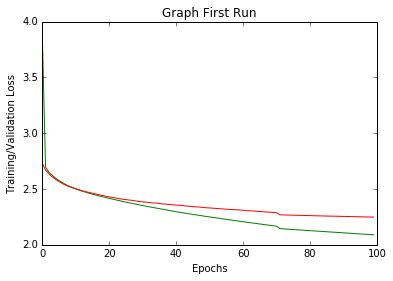

In [18]:
#Test Set
scores_valid, layers_valid = FwdPass(minimum_w,minimum_b,layers,0,xtest,valid_examples)
predicted_class_v = np.argmax(scores_valid, axis=1)
print ("Test accuracy: " , (np.mean(predicted_class_v == ytest)))

counter = 0
CountPerClass = np.zeros(20)
for i in predicted_class_v:
    if(predicted_class_v[counter] == ytest[counter]):
        CountPerClass[i] += 1
    counter += 1
for j in range(20):
    print ("Class ", j+1, "Accuracy is", CountPerClass[j], "/500" , ", Accuracy = ", float(CountPerClass[j])/500)

plotter.plot(range(Epochs),Total_Training_Losses, 'g')
plotter.plot(range(Epochs),Total_Validation_Losses, 'r')
plotter.xlabel('Epochs')
plotter.ylabel('Training/Validation Loss')
plotter.title('Graph First Run')
plotter.show()

('Test accuracy: ', 0.3423)


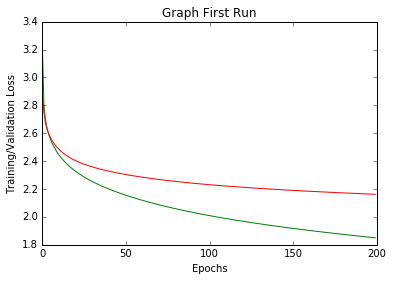

In [357]:
#Test Set
#One of the old runs/ missing architecture and Hyper Parameters
scores_valid, layers_valid = FwdPass(minimum_w2,minimum_b2,layers,0,xtest,valid_examples)
predicted_class_v = np.argmax(scores_valid, axis=1)
print ("Test accuracy: " , (np.mean(predicted_class_v == ytest)))

plotter.plot(range(Epochs),Total_Training_Losses2, 'g')
plotter.plot(range(Epochs),Total_Validation_Losses2, 'r')
plotter.xlabel('Epochs')
plotter.ylabel('Training/Validation Loss')
plotter.title('Graph First Run')
plotter.show()